##### Observations of Snow from space - snow phenology

##### What does this notebook do?
This notebook describes

In [ ]:
import sys
import warnings
import datacube
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import pandas as pd
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff
import os

sys.path.append('../10_Scripts')
import SpatialTools
import gdal
import DEADataHandling
import DEAPlotting

In [ ]:
# Connect to datacube database
dc = datacube.Datacube(app='Snow monitoring with Landsat')


output='results/nsw/notebook/'

In [ ]:
# lat, lon, buffer_m, buffer_n = -36.86895, 147.276, 30000, 30000 #vic
# lat, lon, buffer_m, buffer_n = -41.56728, 147.67106, 10000, 10000 #tas ben lomond
lat, lon, buffer_m, buffer_n = -36.46, 148.26, 5000, 5000 #nsw
# time_range = ('2010-01-01', '2018-12-31')
# time_range1 = ('2005-01-01', '2005-12-31')
time_range = ('2017-01-01', '2017-12-31')
time_range1 = ('2010-01-01', '2018-12-31')
resolution = (-25, 25)

# why 0.3
landsat_goodquality_prop = 0.30

# working out thresholds - geotiff for a number of different ones (methods for verification etc)
# fine tuned for different elevations.. 
#- trees change at different altidudes etc.. (depeding on region accurate thesholds can vary usually btwn 0.0-0.5)
ndsi_threshold = 0.2
ndvi_threshold = 0.3
ndwi_threshold = 0.15
red_threshold = 1000

In [6]:
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}
query1 = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range1,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}

In [3]:
# landsat_ds3 = DEADataHandling.load_clearlandsat(dc=dc, 
#                                                product = 'nbart',
#                                                query=query, 
#                                                sensors=['ls5', 'ls7', 'ls8'],
#                                                bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
#                                                masked_prop=landsat_goodquality_prop,
#                                                mask_pixel_quality=False,
#                                                ls7_slc_off=True)
landsat_ds4 = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query, 
                                               sensors=['ls5', 'ls7', 'ls8'],
                                               bands_of_interest=['red', 'green', 'blue', 'nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=False,
                                                dask_chunks={},
                                               ls7_slc_off=True)

NameError: name 'dc' is not defined

In [8]:
valid_ds3 = np.isfinite(landsat_ds3.swir1)
valid_ds4 = np.isfinite(landsat_ds4.swir1)

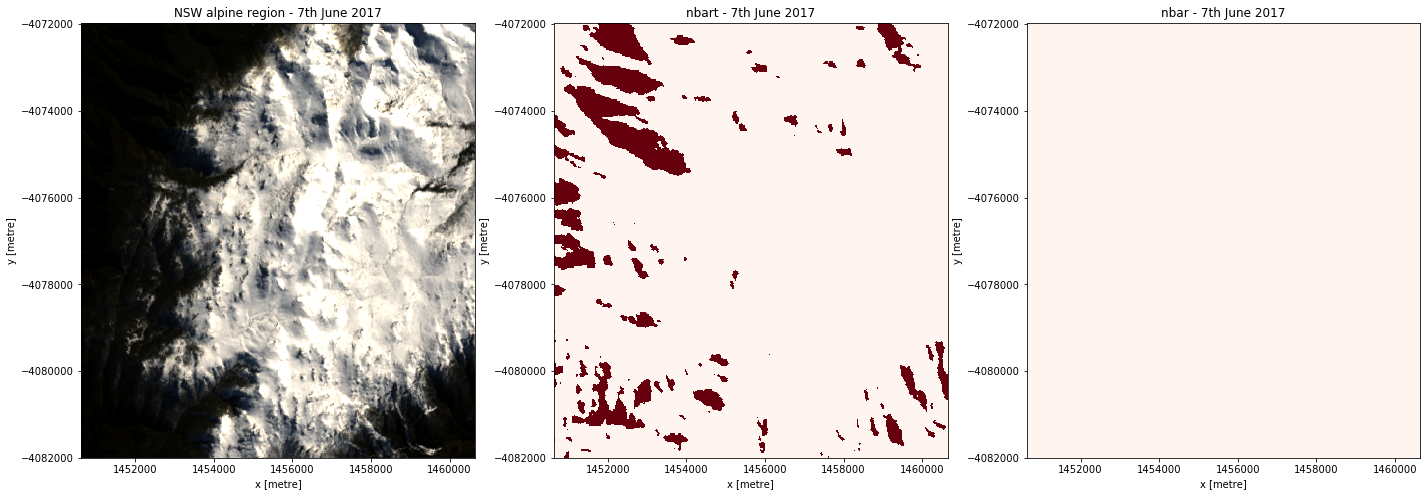

In [11]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, 
                         figsize = (24, 8),
                        #gridspec_kw={'width_ratios': [9,9,10]}
                        )
i=18
a=valid_ds3.isel(time=i).plot(ax=axes[1], add_colorbar=False, cmap='Reds_r')
b=valid_ds4.isel(time=i).plot(ax=axes[2], add_colorbar=False, cmap='Reds_r')
c=landsat_ds2[['red', 'green', 'blue']].isel(time=i).to_array().plot.imshow(robust=True, ax=axes[0])
a.set_clim(0,1)
b.set_clim(0,1)
axes[0].set_title('NSW alpine region - 7th June 2017')
axes[1].set_title('nbart - 7th June 2017')
axes[2].set_title('nbar - 7th June 2017')
plt.savefig('nbarvnbart.png')

In [97]:
# Preview area that data will be loaded for:
# DEAPlotting.display_map(y=query['y'], x=query['x'])

In [10]:
# creating a snow mask
snow_mask = dict(    #cloud_acca='no_cloud',
                     cloud_fmask='no_cloud',
                     #cloud_shadow_acca='no_cloud_shadow',
                     cloud_shadow_fmask='no_cloud_shadow',
                     blue_saturated=False,
                     green_saturated=False,
                     red_saturated=False,
                     nir_saturated=False,
                     swir1_saturated=False,
                     swir2_saturated=False,
                     contiguous=True)

landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query,
                                               mask_dict=snow_mask,
                                               sensors=['ls8', 'ls7', 'ls5'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=True)

snow_mask1 = dict(   cloud_acca='no_cloud',
                     #cloud_fmask='no_cloud',
                     cloud_shadow_acca='no_cloud_shadow',
                     #cloud_shadow_fmask='no_cloud_shadow',
                     blue_saturated=False,
                     green_saturated=False,
                     red_saturated=False,
                     nir_saturated=False,
                     swir1_saturated=False,
                     swir2_saturated=False,
                     contiguous=True)

landsat_ds1 = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query,
                                               mask_dict=snow_mask1,
                                               sensors=['ls8', 'ls7', 'ls5'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=True)
landsat_ds2 = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query,
                                               #mask_dict=snow_mask,
                                               sensors=['ls8', 'ls7', 'ls5'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=False,
                                               ls7_slc_off=True)


Loading ls8
    Loading 23 filtered ls8 timesteps
Loading ls7
    Loading 11 filtered ls7 timesteps
Loading ls5
    Skipping ls5; no valid data for query
Combining and sorting ls8, ls7 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls8
    Loading 25 filtered ls8 timesteps
Loading ls7
    Loading 9 filtered ls7 timesteps
Loading ls5
    Skipping ls5; no valid data for query
Combining and sorting ls8, ls7 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls8
    Loading 23 filtered ls8 timesteps
Loading ls7
    Loading 9 filtered ls7 timesteps
Loading ls5
    Skipping ls5; no valid data for query
Combining and sorting ls8, ls7 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [1]:
landsat_ds10 = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query1,
                                               mask_dict=snow_mask1,
                                               sensors=['ls7','ls8'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=False,
                                               ls7_slc_off=True)

NameError: name 'DEADataHandling' is not defined

In [ ]:
# comparison of acca v fmask (example time, and produce the freq plot with each...)
# nbar v nbart?

In [12]:
valid_ds = np.isfinite(landsat_ds.swir1)
valid_ds1 = np.isfinite(landsat_ds1.swir1)


In [71]:
valid_ds10 = np.isfinite(landsat_ds10.swir1)

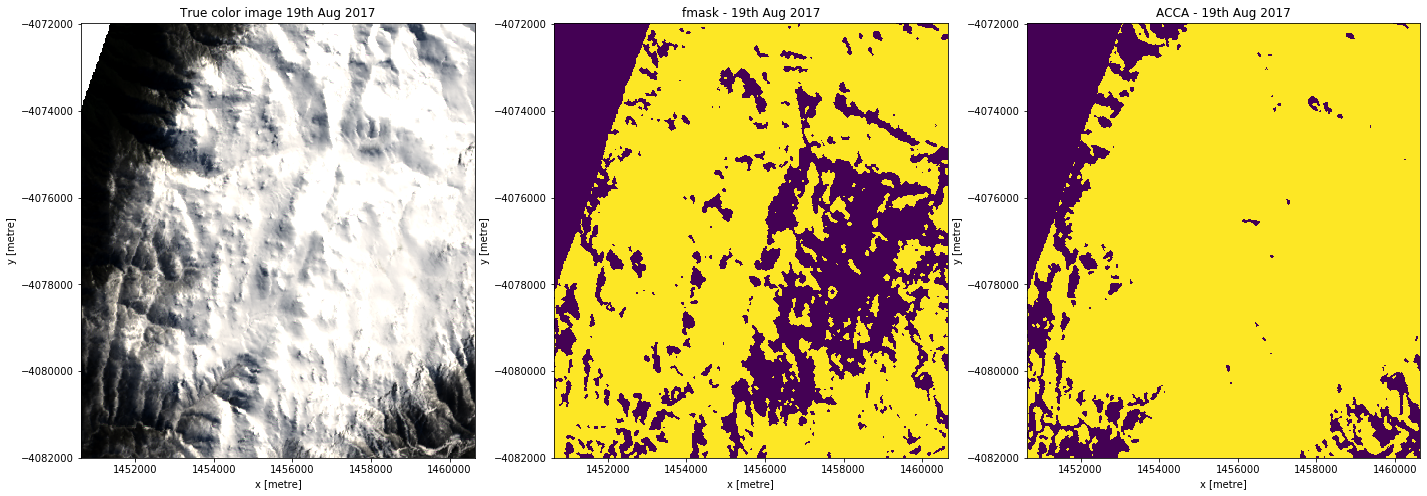

In [23]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, 
                         figsize = (24, 8),
                        #gridspec_kw={'width_ratios': [9,9,9]}
                        )
i=18
valid_ds.isel(time=22).plot(ax=axes[1], add_colorbar=False)
valid_ds1.isel(time=22).plot(ax=axes[2], add_colorbar=False)
landsat_ds2[['red', 'green', 'blue']].isel(time=20).to_array().plot.imshow(robust=True, ax=axes[0])
axes[1].set_title('fmask - 19th Aug 2017')
axes[2].set_title('ACCA - 19th Aug 2017')
axes[0].set_title('True color image 19th Aug 2017')
plt.savefig('snowmask.png')

In [123]:
# valid_ds2.isel(time=37).plot(figsize=(8,8))

In [21]:
# see  snow from space notebook
# calculating ndsi (and ndvi/ndwi)
ndsi_ds = (landsat_ds1.green -landsat_ds1.swir1) / (landsat_ds1.green + landsat_ds1.swir1)
ndvi_ds = (landsat_ds1.nir - landsat_ds1.red) / (landsat_ds1.nir + landsat_ds1.red)

# talk about testing an ndwi threshold?
ndwi_ds = (landsat_ds1.green - landsat_ds1.nir)/(landsat_ds1.green + landsat_ds1.nir)
# too high and it removes snow - too low and pixels remain - added up over time, these form outlines of lakes


In [72]:
ndsi_ds10 = (landsat_ds10.green -landsat_ds10.swir1) / (landsat_ds10.green + landsat_ds10.swir1)
ndvi_ds10 = (landsat_ds10.nir - landsat_ds10.red) / (landsat_ds10.nir + landsat_ds10.red)

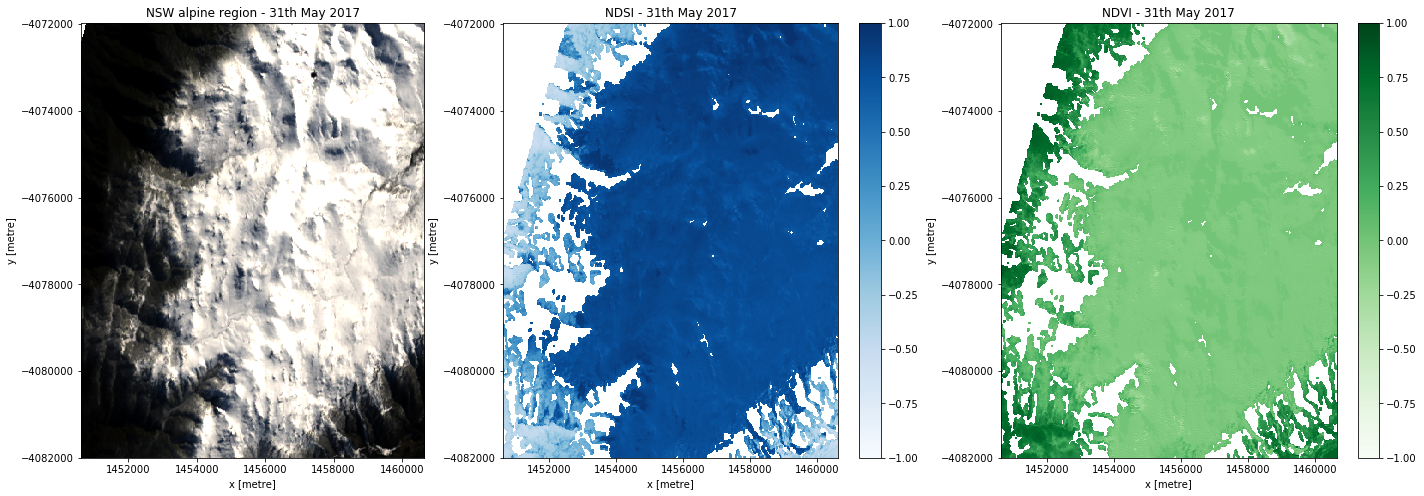

In [30]:



fig, axes = plt.subplots(ncols=3, 
                         figsize = (24, 8),
                        gridspec_kw={'width_ratios': [9,11,11]}
                        )
i=18
a=ndsi_ds.isel(time=i).plot(ax=axes[1], cmap='Blues')
b=ndvi_ds.isel(time=i).plot(ax=axes[2], cmap='Greens')
c=landsat_ds2[['red', 'green', 'blue']].isel(time=17).to_array().plot.imshow(robust=True, ax=axes[0])
axes[0].set_title('NSW alpine region - 31th May 2017')
axes[1].set_title('NDSI - 31th May 2017')
axes[2].set_title('NDVI - 31th May 2017')
a.set_clim(-1,1)
b.set_clim(-1, 1)
plt.savefig('ndsi.png')

In [48]:
snow_ds1 = ndsi_ds > ndsi_threshold
noveg_ds = ndvi_ds < ndvi_threshold
red_ds = landsat_ds1.red >1000
# nowater_ds = ndwi_ds < ndwi_threshold
# snow_ds2 = noveg_ds & snow_ds & red #&nowater_ds
snow_ds = noveg_ds & snow_ds1 & red_ds

# & red
# snow_ds2 = noveg_ds & snow_ds &nowater_ds& red1

In [73]:
snow_ds0 = ndsi_ds10 > ndsi_threshold
noveg_ds10 = ndvi_ds10 < ndvi_threshold
red_ds10 = landsat_ds10.red >1000
# nowater_ds = ndwi_ds < ndwi_threshold
# snow_ds2 = noveg_ds & snow_ds & red #&nowater_ds
snow_ds10 = noveg_ds10 & snow_ds0 & red_ds10


TypeError: 'DataArray' object is not callable

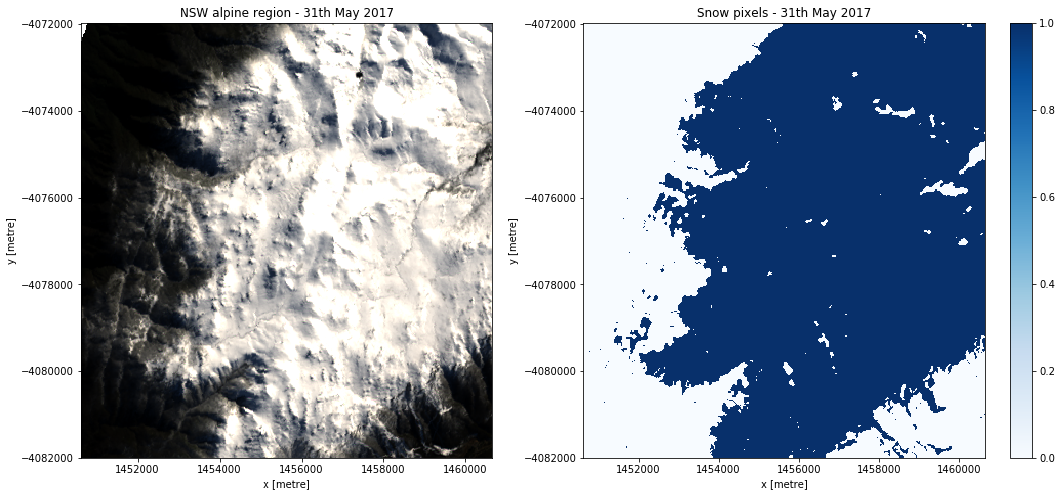

In [51]:
fig, axes = plt.subplots(ncols=2, 
                         figsize = (18, 8),
                        gridspec_kw={'width_ratios': [9,11]}
                        )
i=18

a=landsat_ds2[['red', 'green', 'blue']].isel(time=17).to_array().plot.imshow(robust=True, ax=axes[0])
b=snow_ds.isel(time=i).plot(ax=axes[1], cmap='Blues')
axes[0].set_title('NSW alpine region - 31th May 2017')
axes[1].set_title('Snow pixels - 31th May 2017')
# axes[2].set_title('NDVI - 31th May 2017')
# a.set_clim(-1,1)
b.set_clim(0, 1)
plt.savefig('snow_pixels.png')

In [ ]:
## NDWI

In [35]:
ndwi_ds = (landsat_ds1.green - landsat_ds1.nir)/(landsat_ds1.green + landsat_ds1.nir)

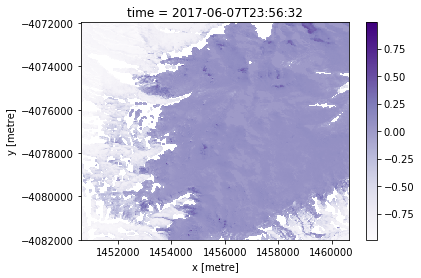

In [47]:
i=19
ndwi_ds.isel(time=i).plot(cmap='Purples')

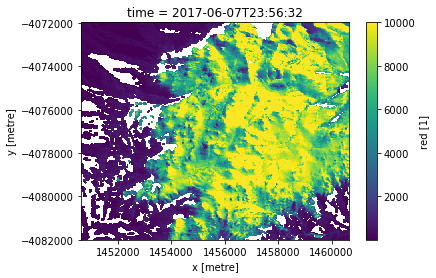

In [46]:
landsat_ds1.red.isel(time=19).plot()

In [52]:
elev=1800

In [53]:
# Importing dem

x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query1 = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),
        # 'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}

# Load the DEM data
dem_ds = dc.load(product='srtm_dem1sv1_0', **query1)
dem_elev = dem_ds.dem > elev

In [89]:
elev=1500
dem_ds = dc.load(product='srtm_dem1sv1_0', **query1)
dem_elev1 = dem_ds.dem > elev


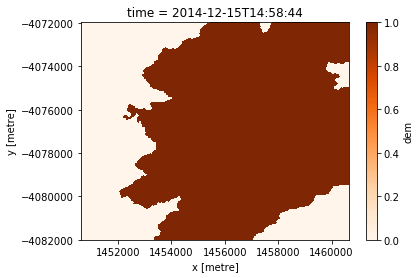

In [57]:
dem_elev.plot(cmap='Oranges')

In [74]:
c=list(range(len(snow_ds.time)))
snow_prop_elev=[]
for i in c:
    d = valid_ds.isel(time=i).values * dem_elev
    f = snow_ds.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev.append(snow)

In [81]:
c=list(range(len(snow_ds10.time)))
snow_prop_elev10=[]
for i in c:
    d = valid_ds10.isel(time=i).values * dem_elev
    f = snow_ds10.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev10.append(snow)

In [90]:
c=list(range(len(snow_ds10.time)))
snow_prop_elev11=[]
for i in c:
    d = valid_ds10.isel(time=i).values * dem_elev1
    f = snow_ds10.isel(time=i).values * dem_elev1
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev11.append(snow)

In [82]:
snow_df10 = pd.DataFrame({'dayofyear':snow_ds10['time.dayofyear'], 'snow_prop_elev':snow_prop_elev10, 'year':snow_ds10['time.year']})
# df.to_csv(output+years+'phenology_freq_'+str(elev)+'.csv')

In [91]:
snow_df11 = pd.DataFrame({'dayofyear':snow_ds10['time.dayofyear'], 'snow_prop_elev':snow_prop_elev11, 'year':snow_ds10['time.year']})

In [64]:
elevation_query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         #'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 
elevation_data = dc.load(product='srtm_dem1sv1_0', **elevation_query)
# elevation_data.dem.plot(figsize=(8,10),cmap='terrain')
elevation_2d = elevation_data.dem_h.squeeze('time')

In [92]:
contour_gdf_1800 = SpatialTools.contour_extract(z_values=1800,
                                            ds_array=elevation_2d,
                                            ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine,
                                            output_shp='extracted_contours_1800.shp')
contour_gdf_1500 = SpatialTools.contour_extract(z_values=1500,
                                            ds_array=elevation_2d,
                                            ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine,
                                            output_shp='extracted_contours_1800.shp')

Operating in single array, multiple z-values mode
    Extracting contour 1800
Exporting contour shapefile to extracted_contours_1800.shp
Operating in single array, multiple z-values mode
    Extracting contour 1500
Exporting contour shapefile to extracted_contours_1800.shp


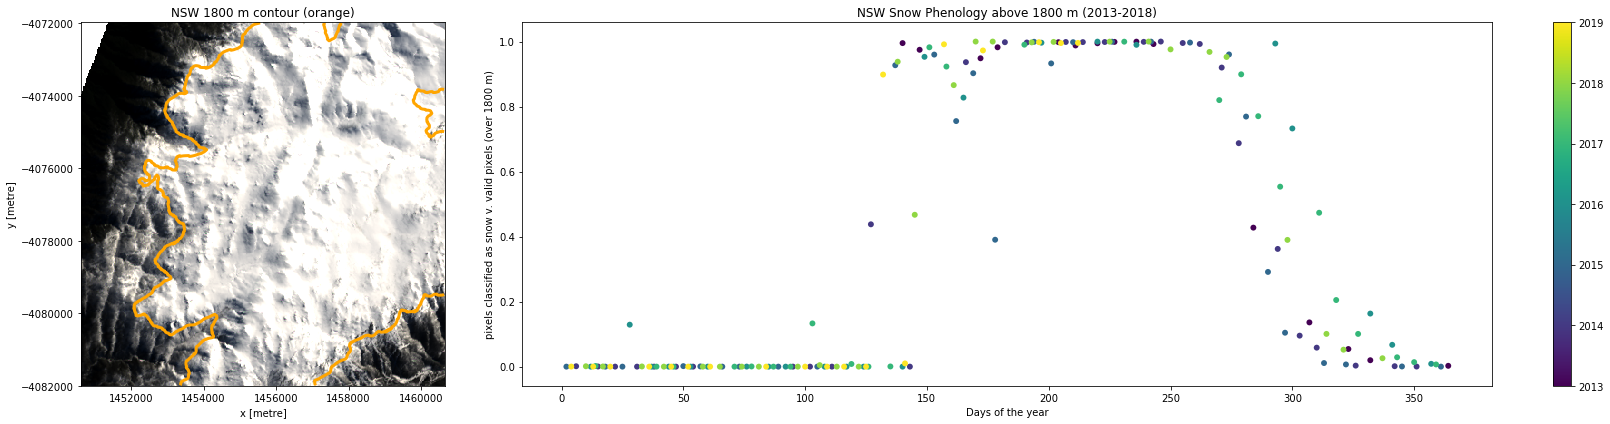

In [84]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("small_area_phen2013_2018.pdf")

# dfs=[
#     (Snow_phen1500, 1500, 3, 0, 'orange'), 
#     (Snow_phen1200, 1200, 0, 3, 'red')
#     ]
# for i, j, k, l, m in dfs:
fig, axes = plt.subplots(ncols=2, 
                         figsize = (25, 6),
                        gridspec_kw={'width_ratios': [2, 5]})

a=landsat_ds2[['red', 'green', 'blue']].isel(time=20).to_array().plot.imshow(ax=axes[0],robust=True)
#     a=contour_gdf_1800.plot(ax=axes[0], linewidth=k, color='mediumblue')
a=contour_gdf_1800.plot(ax=axes[0], linewidth=3, color='orange')
# a=contour_gdf_1200.plot(ax=axes[0], linewidth=l, color='firebrick')
a.title.set_text('NSW 1800 m contour (orange)')
plt.tight_layout()

sp = plt.scatter(snow_df10['dayofyear'], #ndsi_ds.values, 
                snow_df10['snow_prop_elev'], c=snow_df10['year'],
                cmap='viridis', marker='o', edgecolor='none',s=35)
#     plt.ylim(0,2)
plt.title('NSW Snow Phenology above 1800 m (2013-2018)')
plt.xlabel('Days of the year')
plt.ylabel('pixels classified as snow v. valid pixels (over 1800 m)')
fig.colorbar(sp)
pdf.savefig()

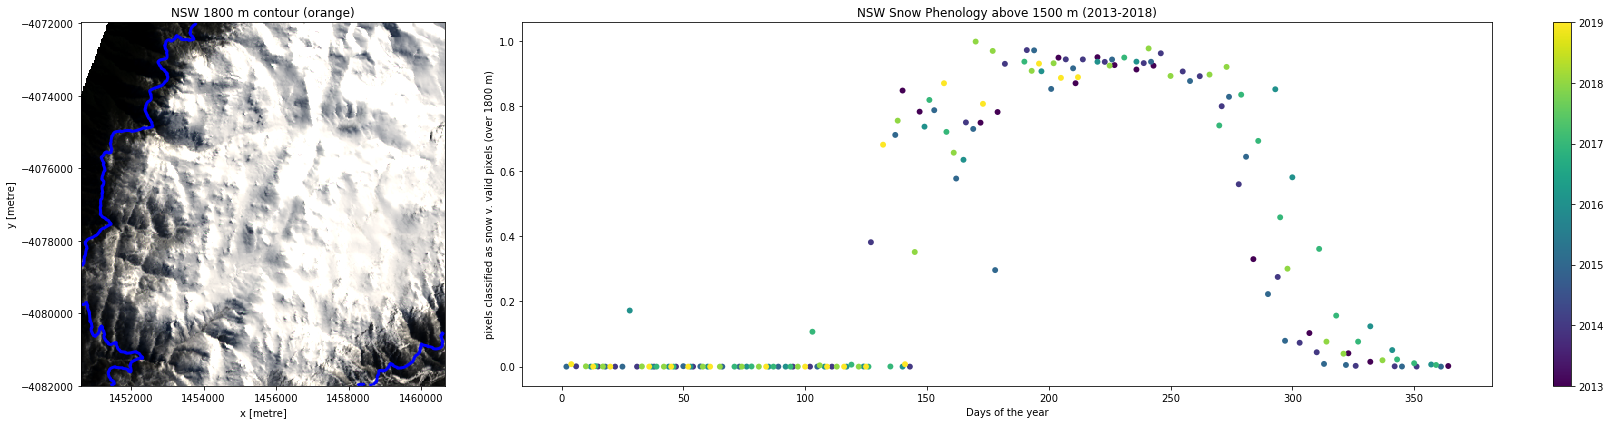

In [96]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("small_area1500_phen2013_2018.pdf")

# dfs=[
#     (Snow_phen1500, 1500, 3, 0, 'orange'), 
#     (Snow_phen1200, 1200, 0, 3, 'red')
#     ]
# for i, j, k, l, m in dfs:
fig, axes = plt.subplots(ncols=2, 
                         figsize = (25, 6),
                        gridspec_kw={'width_ratios': [2, 5]})

a=landsat_ds2[['red', 'green', 'blue']].isel(time=20).to_array().plot.imshow(ax=axes[0],robust=True)
#     a=contour_gdf_1800.plot(ax=axes[0], linewidth=k, color='mediumblue')
a=contour_gdf_1500.plot(ax=axes[0], linewidth=3, color='blue')
# a=contour_gdf_1200.plot(ax=axes[0], linewidth=l, color='firebrick')
a.title.set_text('NSW 1800 m contour (orange)')
plt.tight_layout()

sp = plt.scatter(snow_df11['dayofyear'], #ndsi_ds.values, 
                snow_df11['snow_prop_elev'], c=snow_df11['year'],
                cmap='viridis', marker='o', edgecolor='none',s=35)
#     plt.ylim(0,2)
plt.title('NSW Snow Phenology above 1500 m (2013-2018)')
plt.xlabel('Days of the year')
plt.ylabel('pixels classified as snow v. valid pixels (over 1800 m)')
fig.colorbar(sp)
pdf.savefig()

In [ ]:
# comparing decades
# minimum script required to produce above image - and produce for 90s, 00s
# then rolling means to compare decades



In [220]:
# lat, lon, buffer_m, buffer_n = -36.3, 148.35, 35000, 45000
lat, lon, buffer_m, buffer_n = -36.3, 148.35, 30000, 40000
# lat1, lon1, buffer_m1, = -36.86895, 147.276, 10000, #10000 #vic

# lat1, lon1, buffer_m1 = -36.435, 148.29, 8000
# Set range of time to return data from both Landsat and Sentinel 2
time_range = ('2017-10-01', '2017-10-17')
resolution = (-25, 25)
landsat_goodquality_prop = 0.10

ndsi_threshold = 0.0
ndvi_threshold = 0.3

ndwi_threshold = 0.15

x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query1 = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 

In [221]:
snow_mask = dict(                cloud_acca='no_cloud',
                                 #cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 #cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)

landsat_ds5 = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query1,
                                               mask_dict=snow_mask,
                                               sensors=['ls5','ls7','ls8'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=True)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Loading 2 filtered ls7 timesteps
Loading ls8
    Loading 2 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [223]:
landsat_ds6 = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query1,
                                               #mask_dict=snow_mask,
                                               sensors=['ls8', 'ls7', 'ls5'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=False,
                                               ls7_slc_off=True)

Loading ls8
    Loading 2 filtered ls8 timesteps
Loading ls7
    Loading 2 filtered ls7 timesteps
Loading ls5
    Skipping ls5; no valid data for query
Combining and sorting ls8, ls7 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [222]:
ndsi_ds = (landsat_ds5.green - landsat_ds5.swir1) / (landsat_ds5.green + landsat_ds5.swir1)
ndvi_ds = (landsat_ds5.nir - landsat_ds5.red) / (landsat_ds5.nir + landsat_ds5.red)
ndwi_ds = (landsat_ds5.green - landsat_ds5.nir)/(landsat_ds5.green + landsat_ds5.nir)

In [197]:
# ndwi_ds.isel(time=2).plot(cmap='Blues', figsize=(8,8))

In [209]:
snow_ds1 = ndsi_ds > ndsi_threshold
noveg_ds = ndvi_ds < ndvi_threshold
# nowater_ds = ndwi_ds < ndwi_threshold
# snow_ds2 = noveg_ds & snow_ds & red #&nowater_ds
snow_ds = noveg_ds & snow_ds1# &nowater_ds

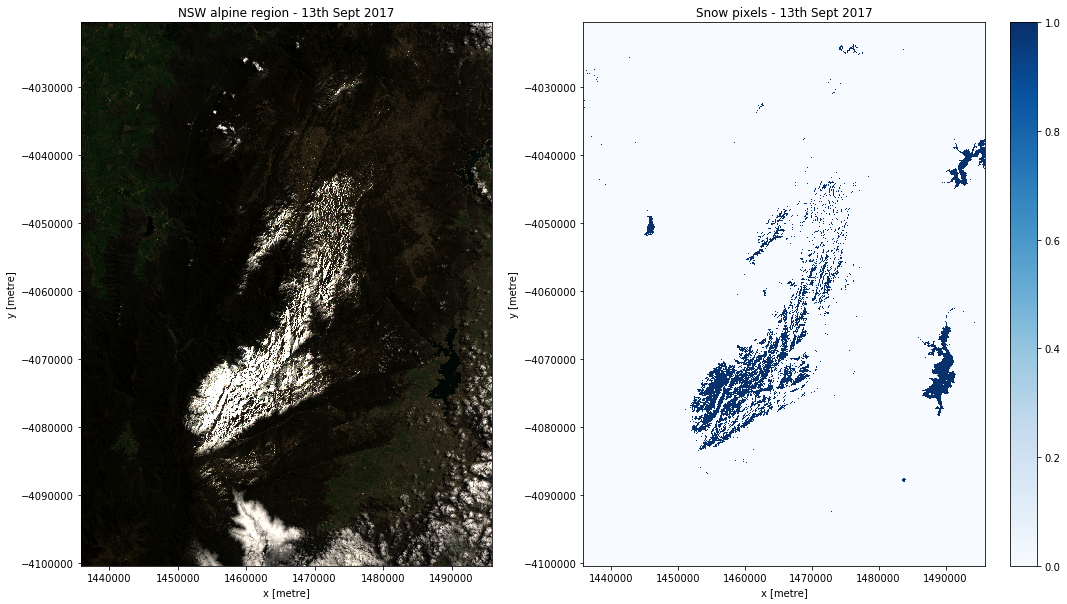

In [226]:
fig, axes = plt.subplots(ncols=2, 
                         figsize = (18, 10),
                        gridspec_kw={'width_ratios': [9,11]}
                        )
i=2

a=landsat_ds6[['red', 'green', 'blue']].isel(time=i).to_array().plot.imshow(robust=True, ax=axes[0])
b=snow_ds.isel(time=i).plot(ax=axes[1], cmap='Blues')
axes[0].set_title('NSW alpine region - 13th Sept 2017')
axes[1].set_title('Snow pixels - 13th Sept 2017')
# axes[2].set_title('NDVI - 31th May 2017')
# a.set_clim(-1,1)
b.set_clim(0, 1)
plt.savefig('nsw_snow_pixels.png')

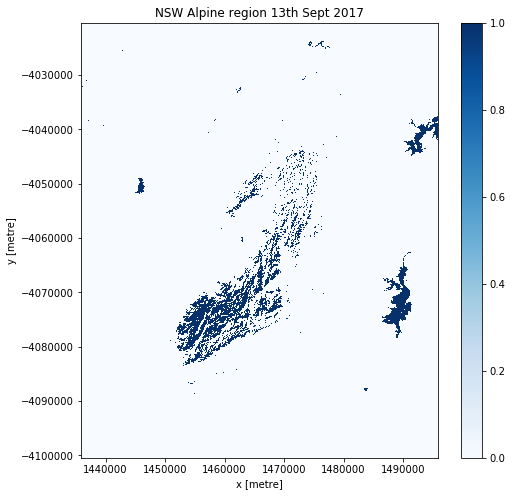

In [227]:
snow_ds.isel(time=2).plot(cmap='Blues', figsize=(8,8))
# plt.title
plt.title('NSW Alpine region 13th Sept 2017')
plt.savefig('nsw_snow_pixels1.png')

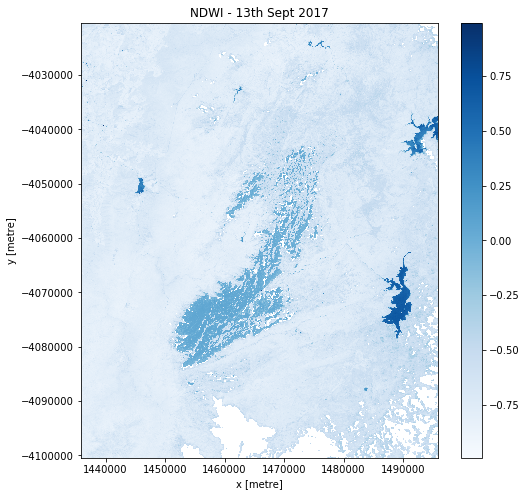

In [228]:
ndwi_ds.isel(time=2).plot(cmap='Blues', figsize=(8,8))
plt.title('NDWI - 13th Sept 2017')
plt.savefig('nsw_ndwi.png')

Text(0.5, 1.0, 'Red band - 13th Sept 2017')

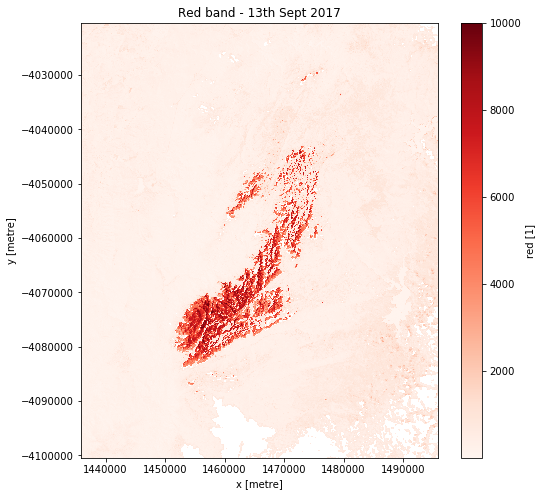

In [243]:
landsat_ds5.red.isel(time=i).plot(cmap='Reds', figsize=(8,8))
plt.title('Red band - 13th Sept 2017')
# plt.savefig('nsw_red.png')

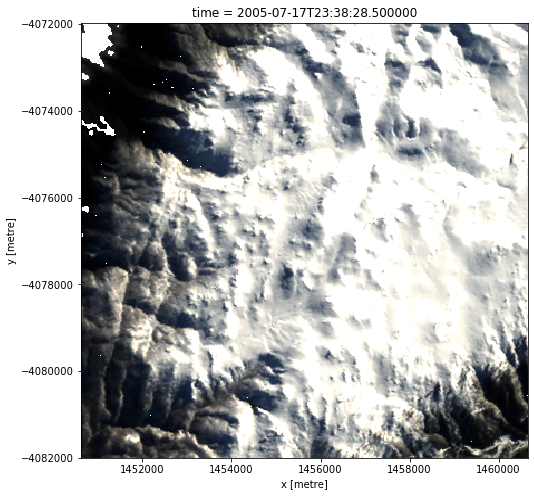

In [89]:
landsat_ds1[['red', 'green', 'blue']].isel(time=165).to_array().plot.imshow(robust=True, figsize=(8, 8))

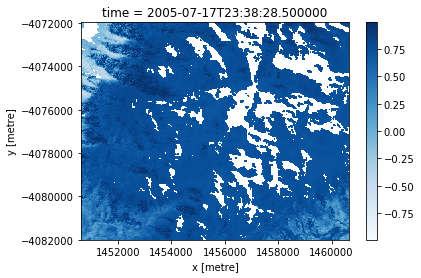

In [88]:
ndsi_ds1.isel(time=165).plot(cmap='Blues')

In [67]:
# define snow/no-snow

snow_ds1 = ndsi_ds > ndsi_threshold
noveg_ds = ndvi_ds < ndvi_threshold
nowater_ds = ndwi_ds < ndwi_threshold
snow_ds = noveg_ds & snow_ds1 & nowater_ds

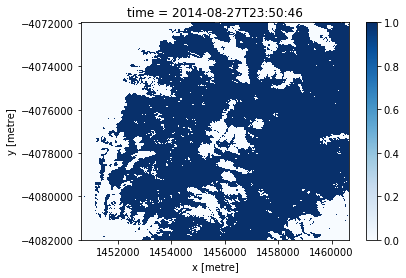

In [69]:
snow_ds.isel(time=135).plot(cmap='Blues')

In [70]:
# decadal plots, normalised sum of all images
red_threshold = 1000
red_ds = landsat_ds.red > red_threshold
snow_ds = noveg_ds & snow_ds1 & nowater_ds & red_ds

In [71]:
# different decades in a loop?

snow_sum = snow_ds.sum(dim='time')
valid_sum = valid_ds.sum(dim='time')
snow_prop = (snow_sum / valid_sum)

# # snow_prop.plot()
# # plt.savefig('decade_example.png')


# snow_sum1=snow_sum.squeeze()

# transform, projection = SpatialTools.geotransform(snow_sum1, (snow_sum1.x, snow_sum1.y), epsg=3577)
# SpatialTools.array_to_geotiff(output+year+'snow.tif',
#               snow_sum1.values, geo_transform = transform, 
#               projection = projection, 
#               nodata_val=np.nan)

# valid_sum1=valid_sum.squeeze()

# transform, projection = SpatialTools.geotransform(valid_sum1, (valid_sum1.x, valid_sum1.y), epsg=3577)
# SpatialTools.array_to_geotiff(output+year+'valid.tif',
#               valid_sum1.values, geo_transform = transform, 
#               projection = projection, 
#               nodata_val=np.nan)

Text(0.5, 1.0, 'NSW alpine region 10s')

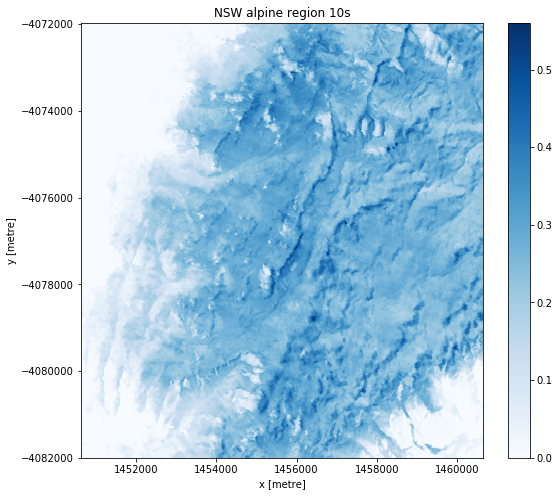

In [72]:
snow_prop.plot(figsize=(9, 8), cmap='Blues')
plt.title('NSW alpine region 10s')

In [ ]:

# snow phenology above a specific elevation
# includes creating contours



# importing a dem for the region

x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query1 = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         #'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 

# Load the DEM data
dem_ds = dc.load(product='srtm_dem1sv1_0', **query1)
dem_elev = dem_ds.dem > elev

# snow_elev = snow_ds.where(dem_elev.squeeze(dim='time'))
# valid_elev = valid_ds.where(dem_elev.squeeze(dim='time'))
# snow_prop = snow_elev/valid_elev

c=list(range(len(snow_ds.time)))
snow_prop_elev=[]
for i in c:
    d = valid_ds.isel(time=i).values * dem_elev
    f = snow_ds.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev.append(snow)
    
    

# mask ndsi dataset with dem_1800, leaving values over 1800 m
# ndsi_elev = ndsi_ds.where(dem_elev.squeeze(dim='time'))
# calculate ndsi mean of valid pixels over 1800 m 
# mean_ndsi_elev = ndsi_elev.mean(dim=('x', 'y'))


# df = pd.DataFrame({'time':snow_ds.time, 'snow_prop_1800':snow_prop_1800, 'pixel_prop':prop_, 'pixel_over_005':prop_rel})
# df.to_csv(output+years+'NEWmask_frequency_prop.csv')

# df = pd.DataFrame({'dayofyear':snow_ds['time.dayofyear'], 'proportion':snow_ds.values, 'year':ndsi_ds['time.year']})
# df.to_csv(output+years+'phenology_freq_1800.csv')

df = pd.DataFrame({'dayofyear':snow_ds['time.dayofyear'], 'snow_prop_elev':snow_prop_elev, 'year':snow_ds['time.year']})
df.to_csv(output+years+'phenology_freq_'+str(elev)+'.csv')